In [9]:
import random

import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.visualization.utils.plot_utils import (
    get_indices_from_probe_suite,
    get_loss_dataset,
)

In [10]:
df = get_loss_dataset("../models/losses/cifar10-20230320_1038")
df.head()

,batch_idx,loss,sample_index,y,y_hat,epoch,stage
0,0,2.550781,42007,1,7,0,train
1,0,2.203125,28785,4,7,0,train
2,0,3.164062,23493,2,7,0,train
3,0,2.347656,153,4,7,0,train
4,0,2.832031,474,2,7,0,train


In [11]:
print(df['stage'][df['stage'] == 'val'].count())
print(df['stage'][df['stage'] == 'train'].count())

227756
4550000


In [12]:
probe_suite = torch.load(f"../data/processed/cifar10/train_probe_suite.pt")

In [13]:
df["epoch"] = df["epoch"].astype(int)

suite_names = {
        "typical": "Typical",
        "atypical": "Atypical",
        "random_outputs": "Random outputs",
        "random_inputs_outputs": "Random inputs and outputs",
        "corrupted": "Corrupted",
}

for suite_attr, suite_name in suite_names.items():
        suite = getattr(probe_suite, suite_attr)
        indices = get_indices_from_probe_suite(suite)
        random.shuffle(indices)
        train_indices = indices[:250]
        val_indices = indices[250:]
        df.loc[df["sample_index"].isin(train_indices), "suite"] = suite_name
        df.loc[df["sample_index"].isin(val_indices), "suite"] = suite_name + " [Val]"

df["suite"] = df["suite"].fillna("Train")

In [14]:
df.head()

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite
0,0,2.550781,42007,1,7,0,train,Train
1,0,2.203125,28785,4,7,0,train,Train
2,0,3.164062,23493,2,7,0,train,Train
3,0,2.347656,153,4,7,0,train,Train
4,0,2.832031,474,2,7,0,train,Train


In [15]:
df["prediction"] = df["y"] == df["y_hat"]

val_df = df[df['stage'] == 'val']
train_df = df[df['stage'] == 'train']

val_df

,batch_idx,loss,sample_index,y,y_hat,epoch,stage,suite,prediction
50000,0,2.263672,772,1,4,0,val,Typical [Val],False
50001,0,2.263672,35878,1,4,0,val,Typical [Val],False
50002,0,2.330078,25506,9,4,0,val,Typical [Val],False
50003,0,2.263672,942,1,4,0,val,Typical [Val],False
50004,0,2.265625,16938,1,4,0,val,Typical,False
...,...,...,...,...,...,...,...,...,...
4777751,19,0.285645,24196,5,5,90,val,Corrupted,True
4777752,19,0.255127,11660,9,9,90,val,Corrupted,True
4777753,19,0.359131,26792,2,2,90,val,Corrupted,True
4777754,19,2.101562,35231,9,8,90,val,Corrupted [Val],False


In [18]:
final_val = val_df.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
final_val.reset_index(inplace=True)
final_val["prediction"] = final_val["prediction"] * 100

final_val

,epoch,suite,prediction
0,0,Atypical,10.8
1,0,Atypical [Val],10.8
2,0,Corrupted,10.0
3,0,Corrupted [Val],12.4
4,0,Random inputs and outputs,10.0
...,...,...,...
905,90,Random inputs and outputs [Val],19.6
906,90,Random outputs,33.2
907,90,Random outputs [Val],38.4
908,90,Typical,100.0


In [22]:
final_train = train_df.groupby(["epoch", "suite"]).agg({"prediction": "mean"})
final_train.reset_index(inplace=True)
final_train["prediction"] = final_train["prediction"] * 100
suites = sorted(final_train["suite"].unique())

In [20]:
# Plot
line_styles = ["solid", "dashed", "dashdot", "dotted"]
marker_list = ["o", "*", "X", "P", "p", "D", "v", "^", "h", "1", "2", "3", "4"]
marker_colors = [
    "tab:gray",
    "tab:green",
    "tab:blue",
    "tab:purple",
    "tab:orange",
    "tab:red",
    "tab:pink",
    "tab:olive",
    "tab:brown",
    "tab:cyan",
]

plot_titles = {
    "cifar10": "CIFAR-10",
    "cifar100": "CIFAR-100",
    "imagenet": "ImageNet",
}

Text(0, 0.5, 'Accuracy (%)')

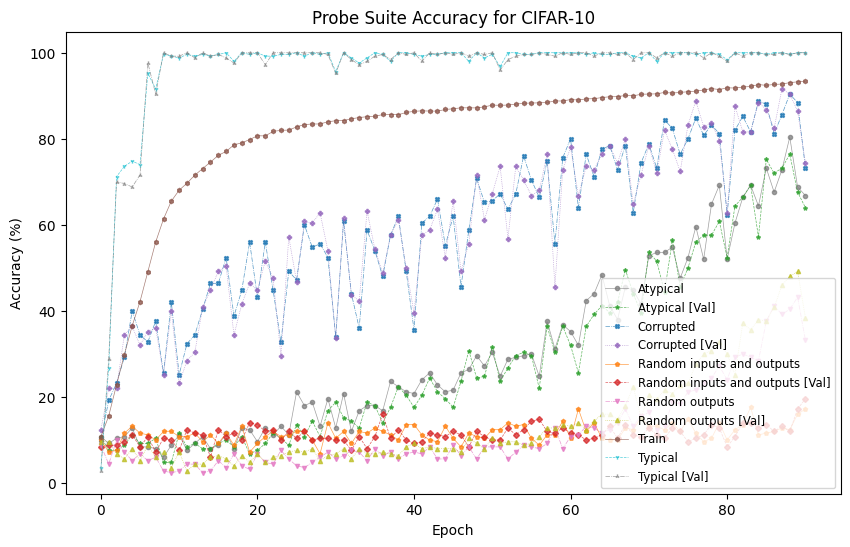

In [23]:
plt.figure(figsize=(10, 6))
plt.title(f"Probe Suite Accuracy for {plot_titles['cifar10']}")
for i, suite in enumerate(suites):
    if "Train" in suite:
        plt.plot(
        final_train[final_train["suite"] == suite]["epoch"],
        final_train[final_train["suite"] == suite]["prediction"],
        label=suite,
        alpha=0.75,
        linewidth=0.5,
        linestyle=line_styles[i % len(line_styles)],
        marker=marker_list[i % len(marker_list)],
        markersize=3,
        color=marker_colors[i % len(marker_colors)],
    )
    else:
        plt.plot(
            final_val[final_val["suite"] == suite]["epoch"],
            final_val[final_val["suite"] == suite]["prediction"],
            label=suite,
            alpha=0.75,
            linewidth=0.5,
            linestyle=line_styles[i % len(line_styles)],
            marker=marker_list[i % len(marker_list)],
            markersize=3,
            color=marker_colors[i % len(marker_colors)],
        )
plt.legend(loc="lower right", fontsize="small")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")